# exp10

exp03 ロジスティック回帰

CV:0.7796483
LB;0.776

https://www.kaggle.com/code/ragnar123/amex-lgbm-dart-cv-0-7977

In [1]:
# ====================================================
# Library
# ====================================================
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
import itertools

import joblib
import random
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from itertools import combinations
from sklearn.linear_model import LogisticRegression

import ipywidgets as widgets
import snappy

from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import pickle


from pytorch_tabnet.pretraining import TabNetPretrainer

from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from pytorch_tabnet.metrics import Metric
# from ipywidgets import interact, Select


# Training & Inference

In [2]:

# ====================================================
# Configurations
# ====================================================
class CFG:
    input_dir = '../feature/exp03_amex-fe/'
    output_dir = '../output/exp10_logistic/'
    seed = 46
    n_folds = 5
    target = 'target'
    boosting_type = 'dart'
    metric = 'binary_logloss'
    model = "logistic"
    ver = "exp10"

# ====================================================
# Seed everything
# ====================================================
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# ====================================================
# Read data
# ====================================================
def read_data():
    train = pd.read_parquet(CFG.input_dir + 'train_fe_plus_plus.parquet')
    test = pd.read_parquet(CFG.input_dir + 'test_fe_plus_plus.parquet')
    return train, test

# ====================================================
# XGB train
# ====================================================

def cat_train(x, y, xt, yt,cat_features):
    print("# of features:", x.shape[1])
    assert x.shape[1] == xt.shape[1]
    
    prams = {
        'depth': 8,
        'iterations':5000,
#         'learning_rate': 0.05,
        'random_state':CFG.seed,
    }

#     watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    watchlist = [(x, 'train'), (xt, 'eval')]
    clf = CatBoostClassifier(**prams)# 5000
    clf.fit(x, y, eval_set=[(xt, yt)], cat_features=cat_features,plot=True, verbose_eval = 100)
#     print('best ntree_limit:', clf.best_ntree_limit)
#     print('best score:', clf.best_score)
    # return clf.predict_proba(xt)[:, 1]
    return clf.predict_proba(xt)[:, 1], clf

def tabnet_train(x, y, xt, yt,cat_features):
    print("# of features:", x.shape[1])
    assert x.shape[1] == xt.shape[1]
    
    prams = {
        'depth': 8,
        'iterations':5000,
#         'learning_rate': 0.05,
        'random_state':CFG.seed,
    }

#     watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    watchlist = [(x, 'train'), (xt, 'eval')]
    clf = CatBoostClassifier(**prams)# 5000
    clf.fit(x, y, eval_set=[(xt, yt)], cat_features=cat_features,plot=True, verbose_eval = 100)
#     print('best ntree_limit:', clf.best_ntree_limit)
#     print('best score:', clf.best_score)
    # return clf.predict_proba(xt)[:, 1]
    return clf.predict_proba(xt)[:, 1], clf



# using amex metric to evaluate tabnet
class Amex_tabnet(Metric):
    
    def __init__(self):
        self._name = 'amex_tabnet'
        self._maximize = True

    def __call__(self, y_true, y_pred):
        amex = amex_metric_numpy(y_true, y_pred[:, 1])
        return max(amex, 0.)

# ====================================================
# Amex metric
# ====================================================
def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)


def xgb_amex(y_pred, y_true):
    return 'amex', amex_metric_np(y_pred,y_true.get_label())


# Created by https://www.kaggle.com/yunchonggan
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
def amex_metric_np(preds: np.ndarray, target: np.ndarray) -> float:
    indices = np.argsort(preds)[::-1]
    preds, target = preds[indices], target[indices]

    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    d = np.sum(target[four_pct_mask]) / np.sum(target)

    weighted_target = target * weight
    lorentz = (weighted_target / weighted_target.sum()).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    n_pos = np.sum(target)
    n_neg = target.shape[0] - n_pos
    gini_max = 10 * n_neg * (n_pos + 20 * n_neg - 19) / (n_pos + 20 * n_neg)

    g = gini / gini_max
    return 0.5 * (g + d)

def amex_metric_numpy(y_true: np.array, y_pred: np.array) -> float:

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting by descring prediction values
    indices = np.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)

In [3]:
seed_everything(CFG.seed)
train, test = read_data()


In [4]:
# Get feature list
features = [col for col in train.columns if col not in ['customer_ID', CFG.target]]
# all_data = features.extend("customer_ID")


train.fillna(value=0, inplace=True)
test.fillna(value=0, inplace=True)

## infを含むデータを外れ値（1000000000）に置換
train = train.replace([np.inf, -np.inf],1000000000)
test = test.replace([np.inf, -np.inf],1000000000)

# Create a numpy array to store test predictions
test_predictions = np.zeros(len(test))
# Create a numpy array to store out of folds predictions
oof_predictions = np.zeros(len(train))

trainid = train["customer_ID"]
testid = test["customer_ID"]



# cid = []
# cids = []

pred = []
oof_preds = []
test_preds = []
cids = []
tr_target = []

# 標準化
sc = StandardScaler()

kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[CFG.target])):
    print(' ')
    print('-'*50)
    print(f'Training fold {fold} with {len(features)} features...')
    
    x_train, x_val = train[features].iloc[trn_ind], train[features].iloc[val_ind]
    y_train, y_val = train[CFG.target].iloc[trn_ind], train[CFG.target].iloc[val_ind]
    
    ## 標準化
    x_train = sc.fit_transform(x_train[features])
    x_val = sc.fit_transform(x_val[features])
    
    
#     cid = train["customer_ID"].loc[val_ind]
    model = LogisticRegression(C = 0.5)
    model.fit(x_train, y_train)

    print(f'start Training fold {fold}')
#     model.fit(np.array(x_train),]
#                     np.array(y_train.values.ravel()),
#                     eval_set = [(np.array(x_val), np.array(y_val.values.ravel()))],
#                     max_epochs = 1,#50
#                     patience = 1,#50
#                     batch_size = 512,
#                     eval_metric = ['auc', 'accuracy', Amex_tabnet]) # Last metric is used for early stoppin
    
    print(f'save fold{fold} model')
    file_path = f"{CFG.output_dir}{CFG.model}_fold{fold}"
    pickle.dump(model, open(file_path, 'wb'))
#     saved_filepath = model.save_model(file_path)
    
#     oof_predictions[valid_idx] = model.predict_proba(x_val.values)[:, 1]
    pred = model.predict_proba(np.array(x_val))[:, 1]
    oof_preds.extend(pred)
    tr_target.extend(y_val)
    
#     preds.extend(oof_predictions)
    print("oof_preds : ",len(oof_preds))
    
    fold_score = amex_metric(y_val, pred)
    print(f"{fold} score is : ",fold_score)

    # Add to out of folds array
#     oof_predictions[val_ind] = val_pred
    
    # OOF用のcustomer_IDをExtend
    cids.extend(train["customer_ID"].loc[val_ind])
    # test predct
    test_preds.append(model.predict_proba(sc.fit_transform(test[features]))[:, 1])
#     print(f'OOF score across folds: {amex_metric_numpy(target, oof_predictions.flatten())}')

#     # Compute fold metric
    del x_train, x_val, y_train, y_val
    gc.collect()


# # Compute out of folds metric
# score = amex_metric(train[CFG.target], preds)
# print(f'Our out of folds CV score is {score}')
# test_predictions = np.mean(preds,axis = 0)

# dic_oof = {
#     "customer_ID":cids,
#     "target":train[CFG.target],
#     "tabnet_oot":oof_predictions
# }

# # Create a dataframe to store out of folds predictions
# oof_df = pd.DataFrame(dic_oof)
# # oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
# oof_df.to_csv(f'{CFG.output_dir}oof_{CFG.ver}_{CFG.model}_{score}_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)


# # Create a dataframe to store test predictionS
# test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
# test_df.to_csv(f'{CFG.output_dir}test_{CFG.model}_{score}_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)



 
--------------------------------------------------
Training fold 0 with 1460 features...
start Training fold 0
save fold0 model
oof_preds :  91783
0 score is :  0.7812529517674436
 
--------------------------------------------------
Training fold 1 with 1460 features...
start Training fold 1
save fold1 model
oof_preds :  183566
1 score is :  0.7783840882954012
 
--------------------------------------------------
Training fold 2 with 1460 features...
start Training fold 2
save fold2 model
oof_preds :  275349
2 score is :  0.7780324251111432
 
--------------------------------------------------
Training fold 3 with 1460 features...
start Training fold 3
save fold3 model
oof_preds :  367131
3 score is :  0.7807707063391179
 
--------------------------------------------------
Training fold 4 with 1460 features...
start Training fold 4
save fold4 model
oof_preds :  458913
4 score is :  0.7798016685600857


In [7]:

score = amex_metric(tr_target, oof_preds)
print(f'Our out of folds CV score is {score}')

# Compute out of folds metric
test_predictions = np.mean(test_preds,axis = 0)

# Create a dataframe to store test prediction
test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
# test_df.to_csv(f'{CFG.output_dir}test_{CFG.model}_{score}_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)
test_df.to_csv(f'{CFG.output_dir}test_{CFG.ver}_{CFG.model}_{score}_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)


dic_oof = {
    "customer_ID":cids,
    "target":tr_target,
    "tabnet_oot":oof_preds
}


# Create a dataframe to store out of folds predictions
oof_df = pd.DataFrame(dic_oof)
# oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
oof_df.to_csv(f'{CFG.output_dir}oof_{CFG.ver}_{CFG.model}_{score}_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)



Our out of folds CV score is 0.7797058354373319


<AxesSubplot:ylabel='Density'>

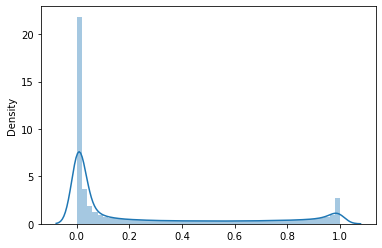

In [8]:
import seaborn as sns

sns.distplot(oof_preds)
# model.predict_proba(sc.fit_transform(test[features]))[:, 1]

In [9]:
# # oof_predictions[valid_idx] = model.predict_proba(x_val.values)[:, 1]
# preds.extend(model.predict_proba(x_val.values)[:, 1])
# #     print("cid : ",len(cid))
# print("preds : ",len(preds))

# # Add to out of folds array
# # oof_predictions[valid_idx] = val_pred

# # OOF用のcustomer_IDをExtend
# cids.extend(train["customer_ID"].loc[val_ind])

# # test predct
# test_predictions += model.predict_proba(test.values)[:, 1]/5
# print(f'OOF score across folds: {amex_metric_numpy(target, oof_predictions.flatten())}')
oof_df

,customer_ID,target,tabnet_oot
0,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0,0.007773
1,00031e8be98bc3411f6037cbd4d3eeaf24b3ae221682b7...,0,0.028697
2,0003e58375faf90552b2861c1ccea4ee5757827cbb6ecd...,0,0.015999
3,0004837f0c785928a29a6f83f70f4a1c54caec483a773f...,0,0.212291
4,0005e52a3fa31b7eed49ceb576f011433ee2578833cd3f...,1,0.821835
...,...,...,...
458908,fffd765f1f5fa550f044acb297092807227f4742fa11bb...,0,0.027059
458909,fffdc0cf228085b4275b38ebe6eb915766af3fecb2ae28...,0,0.000208
458910,fffeb188719a2fcf32cb4c8d0cc49180b6863eef55dbb9...,0,0.506349
458911,fffee847c5c1af7dbdd36d98fea882893256c422cde86c...,0,0.005911
